In this notebook, we get to have a little fun with trying make predictions about a particular cinematic year.<br>
The year 2000 was chosen to test the model's accuracy at making predictions, while limiting the range of training data.<br>
A search will be performed to find the best range of years immediately preceeding the test year to use for training.<br>
The model will attempt to predict average revenues for actors who appeared in movies the year following the training year span, the year 2000.

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import (train_test_split, KFold)
from functools import partial
from collections import defaultdict
import pickle

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


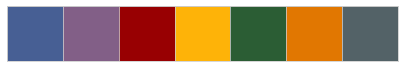

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
actor_df = pd.read_json('../data/capstone2_optimized_target_ref.json')

In [6]:
# observed DataFrame before aggregation
actor_df.head()

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0
9,2,Mark Hamill,533642,Child's Play,4.524793e+07,1.007699e+07,3.517094e+07,67.733081,0,0,...,0,0,1,0,0,0,0,0,0,0
10,2,Mark Hamill,382322,Batman: The Killing Joke,4.049338e+06,3.754353e+06,2.949849e+05,64.830900,0,1,...,0,0,0,0,0,0,0,0,0,0


I need to create a function to sort the observations for any prediction year and chosen training year range.

In [7]:
def get_log_revenue(data):
    """Returns DataFrame with log of revenue"""
    # create copy of dataset to return
    copy_df = data.copy()
    # take log of dataset copy
    copy_df['revenue'] = np.log(copy_df['revenue'])
    
    return copy_df

In [8]:
def aggregate_data(data):
    """Return aggregated DataFrame grouped by each actor"""
    # aggregate while making counts of genres and taking the average of all other values
    agg_actor_df = data.groupby('person_id').agg(
        {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
         'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 
         'runtime': np.mean, 'usa': 'first', 'vote_average': np.mean, 
         'vote_count': np.mean, 'action': np.sum, 'adventure': np.sum, 
         'animation': np.sum, 'comedy': np.sum, 'crime': np.sum, 'drama': np.sum, 
         'family': np.sum, 'fantasy': np.sum, 'history': np.sum, 'horror': np.sum, 
         'music': np.sum, 'mystery': np.sum, 'romance': np.sum, 'science_fiction': np.sum, 
         'thriller': np.sum, 'war': np.sum, 'western': np.sum})
    
    return agg_actor_df

In [9]:
def get_target_year_data(all_years_df, target_year, predictor_years_length=10):
    """Return data from range of previous years and target to predict on specified date"""
    # set range of data to use for training
    training_years_start = target_year - predictor_years_length - 1
    training_years_end = target_year - 1
    # extract data to build models to predict on specified target year
    training_actor_df = all_years_df[
        (all_years_df['release_date'] >= training_years_start) & 
        (all_years_df['release_date'] < training_years_end)]
    # extract data for target year
    test_actor_df = all_years_df[all_years_df['release_date'] == target_year]    
    # aggregate date grouped by actor
    training_df = aggregate_data(get_log_revenue(training_actor_df))
    test_df = aggregate_data(get_log_revenue(test_actor_df))

    return training_df, test_df

In [10]:
# break off actors who worked in the 90s to predict on the year 2000
nineties_training_df, nineties_test_df = get_target_year_data(actor_df, 2000)

Now that I have the data extracted by the desired years, I will separate it into feature and target DataFrames.

In [11]:
# separate training data into features and target
nineties_X_train = nineties_training_df.drop('revenue', axis=1)
nineties_y_train = nineties_training_df['revenue']
nineties_X_test = nineties_test_df.drop('revenue', axis=1)
nineties_y_test = nineties_test_df['revenue']

Now, I will set up the cross validation machine.

In [12]:
def gradient(labels, preds, delta):
    """Return gradient of Pseudo-Huber loss"""
    errors = preds - labels
    scale = delta**2 + errors**2
    grad = errors * np.power(scale, -0.5)
    
    return grad

In [13]:
def hessian(labels, preds, delta):
    """Return hessian of Pseudo-Huber loss"""
    errors = labels - preds
    scale = delta**2 + errors**2
    hess = delta**2 * np.power(scale, -3/2.0)
    
    return hess

In [14]:
def pseudo_huber(preds, dtrain, delta):
    """Return gradient and hessian of Pseudo-Huber loss"""
    labels = dtrain.get_label()
    grad = gradient(labels, preds, delta=delta)
    hess = hessian(labels, preds, delta=delta)
    
    return grad, hess

In [15]:
def eval_error(preds, dtrain):
    """Return mean absolute error in dollar values"""
    labels = dtrain.get_label()
    # transform data from log form
    errors = np.exp(preds) - np.exp(labels)
    mae_dollars = np.mean(np.absolute(errors))
    
    return '$_mae', mae_dollars

In [16]:
def get_xgbr_train(dtrain, dtest, params={}, 
                   max_boost_round=500, early_stopping_limit=100):
    """Return trained Learning API XGBoost model and training results"""
    # instantiate empty dict to store evaluation metrics
    results = {}
    
    # add operational parameters
    params['disable_default_eval_metric'] = 1
    params['tree_method'] = 'gpu_hist'
    
    # set evaluation data
    watchlist = [(dtrain, 'train'), (dtest, 'test')]

    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=10)
    
    # instantiate regressor
    model = xgb.train(params, dtrain, num_boost_round=max_boost_round, evals=watchlist, 
                      obj=train_pseudohuber, feval=eval_error, 
                      early_stopping_rounds=early_stopping_limit, 
                      evals_result=results, verbose_eval=False)
            
    return model, results

In [17]:
def get_scratch_cv(X_train, y_train, X_test, y_test, params={}, 
                   max_boost_round=500, early_stopping_limit=100):
    """Return CV results with statistics from best iteration of each fold"""
    # create default dict to hold MAE statistics from each fold
    cv_results = defaultdict(list)
    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    
    # split training data and run 10 folds
    for train_index, test_index in folds.split(X_train, y_train):
        train_features = X_train.iloc[train_index]
        train_target = y_train.iloc[train_index]
        test_features = X_train.iloc[test_index]
        test_target = y_train.iloc[test_index]

        # convert  training data for faster training
        dtrain = xgb.DMatrix(data=train_features, label=train_target, nthread=-1)
        dtest = xgb.DMatrix(data=test_features, label=test_target, nthread=-1)
        
        # instantiate and fit model
        model, results = get_xgbr_train(dtrain, dtest, params, 
                                        max_boost_round, early_stopping_limit)
        
        # convert prediction data for faster training
        dpred = xgb.DMatrix(data=X_test, label=y_test, nthread=-1)
        
        # predict on test data
        preds = model.predict(dpred)
        # compute errors
        errors = np.exp(preds) - np.exp(y_test)
        # calculate MAE for model
        pred_mae = np.mean(np.abs(errors))        
        
        # get iteration with best test MAE
        best_iter = model.best_iteration
        # get training MAE from iteration of best test MAE
        train_mae = results['train']['$_mae'][best_iter]
        # get best test MAE
        test_mae = results['test']['$_mae'][best_iter]
        # get boosting round with best CV test MAE average
        n_boost = best_iter + 1 
        
        # save fold results to default dict
        cv_results['pred_mae'].append(pred_mae)
        cv_results['test_mae'].append(test_mae)
        cv_results['train_mae'].append(train_mae)
        cv_results['n_boost'].append(n_boost)

    return cv_results

In [18]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

Here, I will load the best model found from the Bayesian search and get its hyperparameter values.

In [19]:
# load best trials object from Hyperopt informed search
best_model = pickle.load(open(
    '../data/xgbr_trials_optimized_target/xgbr_trials_7.pkl', 'rb'))

In [20]:
# extract best hyperparameters fot training a boosting model
best_params = best_model.best_trial['result']['params']

Now, I will create a function to print the results from the cross validated prediction.

In [21]:
def print_prediction_results(X_train, y_train, X_test, y_test, params={}, 
                             max_boost_round=500, early_stopping_limit=100):
    """Train model and print prediction error"""
    # get cross validation results
    test_results = get_scratch_cv(X_train, y_train, X_test, y_test, params=params, 
                                  max_boost_round=max_boost_round, 
                                  early_stopping_limit=early_stopping_limit)
    
    # get overall average prediction MAE of the 10 folds
    pred_mean = np.mean(test_results['pred_mae'])
    # get overall average test MAE of the 10 folds
    test_mean = np.mean(test_results['test_mae'])
    # get average number of boosting rounds
    n_boost = np.mean(test_results['n_boost'])
    
    print('Prediction MAE: {}\nCV Test MAE: {}\nBoost Rounds: {}\n'.format(
        make_money(pred_mean), make_money(test_mean), int(np.round(n_boost))))

Now, I will get the prediction results for a boosted model, which uses the default hyperparameter values.

In [22]:
# get validation results on base model, using training data from previous 10 years
print_prediction_results(nineties_X_train, nineties_y_train, 
                         nineties_X_test, nineties_y_test)

Prediction MAE: $60,154,193.13
CV Test MAE: $38,228,820.40
Boost Rounds: 331



Then, this result can be compared with the best tuned model.

In [23]:
# get validation results on best tuned model, using training data from previous 10 years
print_prediction_results(nineties_X_train, nineties_y_train, 
                         nineties_X_test, nineties_y_test, best_params, 
                         max_boost_round=1000, early_stopping_limit=200)

Prediction MAE: $56,652,306.89
CV Test MAE: $34,265,449.60
Boost Rounds: 726



The cross validated test score is fairly close to what was observed, when performance was measure against the full dataset.<br>
The prediction error is significantly larger than what was obtained from the holdout set of the training data.<br>
The models did not use the full range of boosting rounds that they were allowed.

Finally, I would like to optimize the range selected for the training data years.<br>
I will create a function that takes a target year, a number of previous years to pull training data, and hyperparameters for a boosted model.

In [24]:
def test_predictor_year_range(all_years_df, target_year, max_years, params={}, 
                              max_boost_round=500, early_stopping_limit=100):
    """Return DataFrame with CV results over ranges of selected training years"""
    # set length of largest range of predictor years
    predictor_years_max_length = np.arange(1, max_years + 1)
    # create defaultdict to sort CV results
    results_dict = defaultdict(list)
    for num_years in predictor_years_max_length:
        # store number of years used for training data
        results_dict['num_years'].append(num_years)
        # extract data for range of years
        training_df, test_df = get_target_year_data(all_years_df, target_year, num_years)
        # get size of data
        num_training_samples = training_df.shape[0]
        num_actors_to_predict = test_df.shape[0]
        results_dict['num_samples'].append(num_training_samples)
        results_dict['num_targets'].append(num_actors_to_predict)        
        # split data into features and target
        training_X = training_df.drop('revenue', axis=1)
        training_y = training_df['revenue']
        test_X = test_df.drop('revenue', axis=1)
        test_y = test_df['revenue']
        # run 10 fold cross validation and collect results
        test_results = get_scratch_cv(training_X, training_y, 
                                      test_X, test_y, 
                                      params=params, 
                                      max_boost_round=max_boost_round, 
                                      early_stopping_limit=early_stopping_limit)
        # get overall average prediction MAE of the 10 folds
        pred_mean = np.mean(test_results['pred_mae'])
        # get overall average test MAE of the 10 folds
        test_mean = np.mean(test_results['test_mae'])
        # get overall average training MAE of the 10 folds
        train_mean = np.mean(test_results['train_mae'])
        # get average number of boosting rounds
        n_boost = np.mean(test_results['n_boost'])
        # store values in defaultdict
        results_dict['pred_mae'].append(pred_mean)
        results_dict['test_mae'].append(test_mean)
        results_dict['train_mae'].append(train_mean)
        results_dict['n_boost'].append(n_boost)
    # assemble results into DataFrame
    df = pd.DataFrame(results_dict)
    
    return df

In [25]:
# get results DataFrame for training year ranges from one to 20 years each
two_thousand_df = test_predictor_year_range(actor_df, 2000, 20, 
                                            params=best_params, 
                                            max_boost_round=1000, 
                                            early_stopping_limit=200)
two_thousand_df

,num_years,num_samples,num_targets,pred_mae,test_mae,train_mae,n_boost
0,1,738,831,6.026746e+07,11725360.2,1.005331e+06,861.0
1,2,1243,831,5.730004e+07,18303581.9,1.220185e+06,791.0
2,3,1632,831,5.769411e+07,23153824.0,1.615091e+06,778.2
3,4,1938,831,5.966273e+07,29514852.4,1.168555e+06,855.7
4,5,2170,831,5.537117e+07,32250702.2,2.096400e+06,781.8
5,6,2433,831,5.447059e+07,32211892.6,1.615941e+06,863.7
6,7,2630,831,5.703792e+07,34047845.2,2.321045e+06,767.1
7,8,2809,831,5.508957e+07,33078434.8,3.458996e+06,599.4
8,9,2964,831,5.880625e+07,33826726.2,2.867851e+06,757.9
9,10,3136,831,5.665231e+07,34265449.6,2.487281e+06,726.1


The training scores are in line with what was observed in the best hyperparameter search model.<br>
The best span, at 6 years, is split nearly 25:75, test to training.

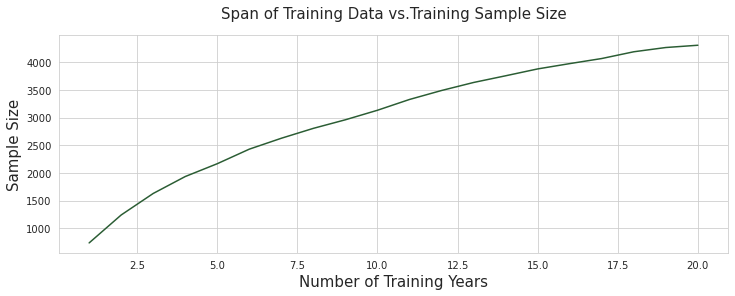

In [26]:
# plot training sample size for training year range from one to twenty years

sns.lineplot(x=two_thousand_df['num_years'], y=two_thousand_df['num_samples'], 
             color=mp.colors(4))

plt.xlabel('Number of Training Years', fontsize=15)
plt.ylabel('Sample Size', fontsize=15)

plt.title('Span of Training Data vs.Training Sample Size', fontsize=15, y=1.05);

The number of training samples increases nearly monotonically throughout the range of training year spans.

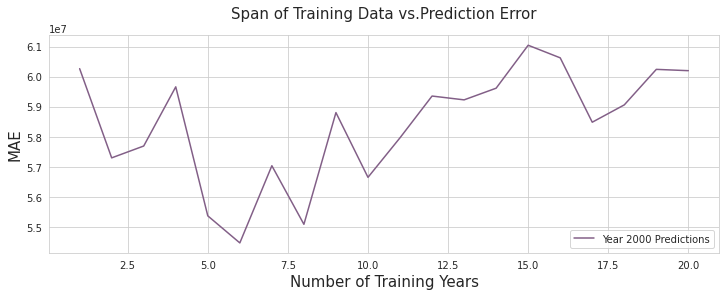

In [27]:
# plot 10 fold CV prediction MAE for training year range from one to twenty years

sns.lineplot(x=two_thousand_df['num_years'], y=two_thousand_df['pred_mae'], 
             label='Year 2000 Predictions', color=mp.colors(1))

plt.xlabel('Number of Training Years', fontsize=15)
plt.ylabel('MAE', fontsize=15)

plt.legend(loc=4)
plt.title('Span of Training Data vs.Prediction Error', fontsize=15, y=1.05);

The optimal number of training years to use is 6.

Finally, I will use this information to extract and split the data, accordingly.

In [28]:
# break off actors who worked in the year 2000 and the previous 6 years to predict on the year 2000
best_training_df, best_test_df = get_target_year_data(actor_df, 2000, 6)

In [29]:
# separate training data into features and target
best_X_train = best_training_df.drop('revenue', axis=1)
best_y_train = best_training_df['revenue']
best_X_test = best_test_df.drop('revenue', axis=1)
best_y_test = best_test_df['revenue']

Now, I can get the best prediction error that the tuned and optimized model can make on actors from the year 2000.

In [30]:
# get validation results on best tuned model for the year 2000, using training data from previous 6 years
print_prediction_results(best_X_train, best_y_train, 
                         best_X_test, best_y_test, best_params, 
                         max_boost_round=1000, early_stopping_limit=200)

Prediction MAE: $54,470,586.98
CV Test MAE: $32,211,892.60
Boost Rounds: 864



Given the reduced sample sizes used for the training and test data, the result is satisfactory.